In [ ]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
bist100 = pd.read_csv("/content/ETH_D1.csv")
bist100.head()

,Time,Open,High,Low,Close,Volume
0,2017-08-17 00:00:00,301.13,312.18,298.00,302.00,7049
1,2017-08-18 00:00:00,302.00,311.79,283.94,293.96,9562
2,2017-08-19 00:00:00,293.31,299.90,278.00,290.91,2172
3,2017-08-20 00:00:00,289.41,300.53,282.85,299.10,2535
4,2017-08-21 00:00:00,299.10,346.52,294.60,323.29,5244


In [ ]:
bist100.rename(columns={"Time":"time","Open":"open","High":"high","Low":"low","Close":"close"}, inplace= True)
bist100.head()

,time,open,high,low,close,Volume
0,2017-08-17 00:00:00,301.13,312.18,298.00,302.00,7049
1,2017-08-18 00:00:00,302.00,311.79,283.94,293.96,9562
2,2017-08-19 00:00:00,293.31,299.90,278.00,290.91,2172
3,2017-08-20 00:00:00,289.41,300.53,282.85,299.10,2535
4,2017-08-21 00:00:00,299.10,346.52,294.60,323.29,5244


In [ ]:
bist100.isnull().sum()

time      0
open      0
high      0
low       0
close     0
Volume    0
dtype: int64

In [ ]:
bist100.isna().any()

time      False
open      False
high      False
low       False
close     False
Volume    False
dtype: bool

In [ ]:
bist100.dropna(inplace=True)
bist100.isna().any()

time      False
open      False
high      False
low       False
close     False
Volume    False
dtype: bool

In [ ]:
bist100['time'] = pd.to_datetime(bist100.time)
bist100.head()
infer_datetime_format=True

In [ ]:
bist100.sort_values(by='time', inplace=True)
bist100.head()

,time,open,high,low,close,Volume
0,2017-08-17,301.13,312.18,298.00,302.00,7049
1,2017-08-18,302.00,311.79,283.94,293.96,9562
2,2017-08-19,293.31,299.90,278.00,290.91,2172
3,2017-08-20,289.41,300.53,282.85,299.10,2535
4,2017-08-21,299.10,346.52,294.60,323.29,5244


In [ ]:
bist100.shape

(2155, 6)

In [ ]:
print("Starting date: ",bist100.iloc[0][0])
print("Ending date: ", bist100.iloc[-1][0])
print("Duration: ", bist100.iloc[-1][0]-bist100.iloc[0][0])

Starting date:  2017-08-17 00:00:00
Ending date:  2023-07-11 00:00:00
Duration:  2154 days 00:00:00


In [ ]:
monthvise= bist100.groupby(bist100['time'].dt.strftime('%B'))[['open','close']].mean().sort_values(by='close')
monthvise.head()

,open,close
time,,
July,953.271747,958.262410
September,987.066500,982.299111
October,1034.486828,1042.683011
August,1067.389706,1071.801471
June,1101.401778,1093.909556


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='cryptoo Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='crypto Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between crypto actual, open and close price')
fig.show()

In [ ]:
bist100.groupby(bist100['time'].dt.strftime('%B'))['low'].min()

time
April        128.62
August       144.21
December      81.79
February     101.21
January      100.91
July         191.84
June         216.00
March         86.00
May          157.55
November     102.36
October      153.45
September    150.03
Name: low, dtype: float64

In [ ]:
monthvise_high= bist100.groupby(bist100['time'].dt.strftime('%B'))['high'].max()
monthvise_low= bist100.groupby(bist100['time'].dt.strftime('%B'))['low'].min()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='crypto high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='crypto low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low crypto price')
fig.show()

In [ ]:
names = cycle(['crypto Open Price','crypto Close Price','crypto High Price','crypto Low Price'])

fig = px.line(bist100, x=bist100.time, y=[bist100['open'], bist100['close'],
                                          bist100['high'], bist100['low']],
             labels={'time': 'Time','value':'crypto value'})
fig.update_layout(title_text='crypto analysis chart', font_size=15, font_color='black',legend_title_text='crypto Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
closedf = bist100[['time','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2155, 2)


In [ ]:
fig = px.line(closedf, x=closedf.time, y=closedf.close,labels={'time':'Time','close':'Close crypto'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='crypto close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
close_crypto = closedf.copy()
del closedf['time']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)


(2155, 1)


In [ ]:
training_size=int(len(closedf)*0.65)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1400, 1)
test_data:  (755, 1)


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)



In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1384, 15)
y_train:  (1384,)
X_test:  (739, 15)
y_test (739,)


In [ ]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel= 'rbf', C= 1e2, gamma= 0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=100.0, gamma=0.1)

In [ ]:
train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)
print(train_predict)
print(test_predict)

Train data prediction: (1384, 1)
Test data prediction: (739, 1)
[[0.10790525]
 [0.10909626]
 [0.10805158]
 ...
 [0.5217547 ]
 [0.51921409]
 [0.53598479]]
[[0.47455061]
 [0.47765902]
 [0.47978517]
 [0.49219535]
 [0.49356756]
 [0.49409485]
 [0.4950224 ]
 [0.49080375]
 [0.48539504]
 [0.47489389]
 [0.47407754]
 [0.4694887 ]
 [0.45312828]
 [0.44941243]
 [0.44014426]
 [0.43506646]
 [0.43221983]
 [0.42787555]
 [0.42297247]
 [0.4173419 ]
 [0.42257227]
 [0.43054119]
 [0.44563384]
 [0.45746534]
 [0.46624229]
 [0.477933  ]
 [0.48689777]
 [0.49545902]
 [0.50593656]
 [0.5135287 ]
 [0.52554687]
 [0.53805187]
 [0.54757667]
 [0.54884602]
 [0.56274176]
 [0.57647322]
 [0.59376694]
 [0.62141707]
 [0.62903678]
 [0.64624321]
 [0.65571635]
 [0.65711317]
 [0.65867781]
 [0.65957319]
 [0.66065223]
 [0.66720992]
 [0.65845195]
 [0.63701424]
 [0.62644256]
 [0.62434364]
 [0.63032902]
 [0.63968804]
 [0.63621376]
 [0.64171279]
 [0.6432471 ]
 [0.6493092 ]
 [0.6365183 ]
 [0.63779454]
 [0.63971798]
 [0.638609  ]
 [0.64

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  252.86207519059167
Train data MSE:  63939.22906969243
Test data MAE:  240.93150050147653
-------------------------------------------------------------------------------------
Test data RMSE:  395.99241022957693
Test data MSE:  156809.98895942952
Test data MAE:  260.8872546612963


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9737807889534382
Test data explained variance regression score: 0.8328939092912162


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8497181645965339
Test data R2 score: 0.832230555328815


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.4173839535033664
Test data MGD:  0.019574068681689916
----------------------------------------------------------------------
Train data MPD:  151.21434656648114
Test data MPD:  52.23716980564418


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'time': close_crypto['time'],
                       'original_close': close_crypto['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['time'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'crypto price','time': 'Time'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2155, 1)
Test predicted data:  (2155, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)

        yhat = svr_rbf.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = svr_rbf.predict(x_input)

        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())

        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
svrdf=closedf.tolist()
svrdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
svrdf=scaler.inverse_transform(svrdf).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(svrdf,labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing crypto price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='crypto')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [ ]:
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1384, 1)
Test data prediction: (739, 1)


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  23.24680704220575
Train data MSE:  540.4140376575467
Test data MAE:  9.672580057803469
-------------------------------------------------------------------------------------
Test data RMSE:  262.2376216749892
Test data MSE:  68768.57022175477
Test data MAE:  161.20287740189403


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9987298844552766
Test data explained variance regression score: 0.9295460746701214


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9987298186944286
Test data R2 score: 0.9264251919568711


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0005124443535397337
Test data MGD:  0.007609317683687412
----------------------------------------------------------------------
Train data MPD:  0.33827606287147755
Test data MPD:  21.51167525268763


In [ ]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'time': close_crypto['time'],
                       'original_close': close_crypto['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['time'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'crypto price','time': 'Time'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=20, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2155, 1)
Test predicted data:  (2155, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)

        yhat = regressor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = regressor.predict(x_input)

        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())

        i=i+1

print("Output of predicted next days: ", len(lst_output))


Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
rfdf=closedf.tolist()
rfdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rfdf=scaler.inverse_transform(rfdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing crypto price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='crypto')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
from sklearn import neighbors

K = time_step
neighbor = neighbors.KNeighborsRegressor(n_neighbors = K)
neighbor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [ ]:
train_predict=neighbor.predict(X_train)
test_predict=neighbor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1384, 1)
Test data prediction: (739, 1)


In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, X_test))

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  71.10976683911721
Train data MSE:  5056.598939913614
Test data MAE:  31.360711464354523
-------------------------------------------------------------------------------------
Test data RMSE:  396.6206424499278
Test data MSE:  157307.93401739348
Test data MAE:  255.44917004961664


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9881426090183009
Test data explained variance regression score: 0.8403168590520362


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9881150432896032
Test data R2 score: 0.83169780887302


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.004938451953058891
Test data MGD:  0.01898990540634103
----------------------------------------------------------------------
Train data MPD:  3.2441681793716586
Test data MPD:  51.758174428716934


In [ ]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'time': close_crypto['time'],
                       'original_close': close_crypto['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['time'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'crypto price','time': 'Time'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2155, 1)
Test predicted data:  (2155, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)

        yhat = neighbor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = neighbor.predict(x_input)

        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())

        i=i+1

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
knndf=closedf.tolist()
knndf.extend((np.array(lst_output).reshape(-1,1)).tolist())
knndf=scaler.inverse_transform(knndf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(knndf,labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing crypto price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='crypto')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1384, 15, 1)
X_test:  (739, 15, 1)


In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22,401
Trainable params: 22,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=2,batch_size=2,verbose=1)

Epoch 1/2
692/692 [==============================] - 15s 14ms/step - loss: 0.0015 - accuracy: 7.2254e-04 - val_loss: 0.0172 - val_accuracy: 0.0014
Epoch 2/2
692/692 [==============================] - 8s 12ms/step - loss: 7.0139e-04 - accuracy: 7.2254e-04 - val_loss: 0.0050 - val_accuracy: 0.0014


In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

24/24 [==============================] - 0s 4ms/step


((1384, 1), (739, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  128.36981357634136
Train data MSE:  16478.809037624633
Train data MAE:  70.65483480574768
-------------------------------------------------------------------------------------
Test data RMSE:  335.09273178977935
Test data MSE:  112287.13889833698
Test data MAE:  283.12383314986994


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9717112998136336
Test data explained variance regression score: 0.9630159951304299


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9612684465629362
Test data R2 score: 0.8798651089659592


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.02387731497355757
Test data MGD:  0.01980129366101301
----------------------------------------------------------------------
Train data MPD:  12.916604532684897
Test data MPD:  43.484330494153824


In [ ]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)


names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'time': close_crypto['time'],
                       'original_close': close_crypto['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['time'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'crypto price','time': 'Time'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2155, 1)
Test predicted data:  (2155, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
grudf=closedf.tolist()
grudf.extend((np.array(lst_output).reshape(-1,1)).tolist())
grudf=scaler.inverse_transform(grudf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])
fig = px.line(grudf,labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing crypto price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='crypto')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=2,batch_size=5,verbose=1)

Epoch 1/2
277/277 [==============================] - 9s 20ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 2/2
277/277 [==============================] - 4s 15ms/step - loss: 0.0016 - val_loss: 0.0042


In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

24/24 [==============================] - 0s 5ms/step


((1384, 1), (739, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict)
)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  142.1557485019855
Train data MSE:  20208.25683215975
Train data MAE:  81.74105089948355
-------------------------------------------------------------------------------------
Test data RMSE:  304.6003502738768
Test data MSE:  92781.37338696845
Test data MAE:  218.71893557991163


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9552929943716867
Test data explained variance regression score: 0.9033508359904099


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9525028066301612
Test data R2 score: 0.9007341331234401


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.04339367040100132
Test data MGD:  0.013841532786204477
----------------------------------------------------------------------
Train data MPD:  18.264497790134563
Test data MPD:  33.28198455373303


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'time': close_crypto['time'],
                       'original_close': close_crypto['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['time'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Crypto price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=20, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2155, 1)
Test predicted data:  (2155, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing crypto price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='crypto')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1384, 15, 1)
X_test:  (739, 15, 1)


In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22,401
Trainable params: 22,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=5,verbose=1)

Epoch 1/20
277/277 [==============================] - 12s 23ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 2/20
277/277 [==============================] - 6s 22ms/step - loss: 6.1255e-04 - val_loss: 0.0014
Epoch 3/20
277/277 [==============================] - 5s 19ms/step - loss: 5.4957e-04 - val_loss: 0.0018
Epoch 4/20
277/277 [==============================] - 6s 22ms/step - loss: 4.6657e-04 - val_loss: 0.0018
Epoch 5/20
277/277 [==============================] - 5s 20ms/step - loss: 4.3142e-04 - val_loss: 6.2231e-04
Epoch 6/20
277/277 [==============================] - 6s 21ms/step - loss: 3.5266e-04 - val_loss: 9.4719e-04
Epoch 7/20
277/277 [==============================] - 5s 19ms/step - loss: 3.7599e-04 - val_loss: 0.0029
Epoch 8/20
277/277 [==============================] - 6s 21ms/step - loss: 2.8448e-04 - val_loss: 0.0019
Epoch 9/20
277/277 [==============================] - 6s 21ms/step - loss: 3.0196e-04 - val_loss: 0.0024
Epoch 10/20
277/277 [=============================

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

24/24 [==============================] - 0s 6ms/step


((1384, 1), (739, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  65.25866347903154
Train data MSE:  4258.693159069485
Train data MAE:  32.437720110678256
-------------------------------------------------------------------------------------
Test data RMSE:  165.0626789023712
Test data MSE:  27245.6879664273
Test data MAE:  109.89850100959913


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9910945227985813
Test data explained variance regression score: 0.9792537483854314


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9899904294487574
Test data R2 score: 0.9708501099314883


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.007757950084494868
Test data MGD:  0.0031527854306410714
----------------------------------------------------------------------
Train data MPD:  3.2798764101913642
Test data MPD:  8.637313081093241


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)


names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'time': close_crypto['time'],
                       'original_close': close_crypto['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['time'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'crypto price','time': 'Time'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2155, 1)
Test predicted data:  (2155, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
grudf=closedf.tolist()
grudf.extend((np.array(lst_output).reshape(-1,1)).tolist())
grudf=scaler.inverse_transform(grudf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])
fig = px.line(grudf,labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing crypto price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='crypto')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1384, 15, 1)
X_test:  (739, 15, 1)


In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 gru (GRU)                   (None, 15, 32)            6336      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 25,377
Trainable params: 25,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=2,batch_size=5,verbose=1)

Epoch 1/2
277/277 [==============================] - 13s 25ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 2/2
277/277 [==============================] - 5s 20ms/step - loss: 0.0013 - val_loss: 0.0169


In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

24/24 [==============================] - 0s 5ms/step


((1384, 1), (739, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  214.33581755542517
Train data MSE:  45939.8426871525
Test data MAE:  97.03803438396123
-------------------------------------------------------------------------------------
Test data RMSE:  613.7408104809977
Test data MSE:  376677.7824498718
Test data MAE:  496.07927026730584


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.902704987122898
Test data explained variance regression score: 0.85346362725431


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8920236609414443
Test data R2 score: 0.5969961939227066


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.03767262026993459
Test data MGD:  0.06556677684679334
----------------------------------------------------------------------
Train data MPD:  29.4795222868007
Test data MPD:  147.63123060972035


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'time': close_crypto['time'],
                       'original_close': close_crypto['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['time'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'crypto price','time': 'Time'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=21, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2155, 1)
Test predicted data:  (2155, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



In [ ]:
lstmgrudf=closedf.tolist()
lstmgrudf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmgrudf=scaler.inverse_transform(lstmgrudf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmgrudf,labels={'value': 'crypto price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing crypto price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='crypto')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [ ]:
finaldf = pd.DataFrame({
    'svr':svrdf,
    'rf':rfdf,
    'knn':knndf,
    'lstm':lstmdf,
    'gru':grudf,
    'lstm_gru':lstmgrudf,
})
finaldf.head()

,svr,rf,knn,lstm,gru,lstm_gru
0,302.00,302.00,302.00,302.00,302.00,302.00
1,293.96,293.96,293.96,293.96,293.96,293.96
2,290.91,290.91,290.91,290.91,290.91,290.91
3,299.10,299.10,299.10,299.10,299.10,299.10
4,323.29,323.29,323.29,323.29,323.29,323.29


In [ ]:
names = cycle(['SVR', 'RF','KNN','LSTM','GRU','LSTM + GRU'])
color_map = {
    'SVR': 'blue',
    'RF': 'dark red',
    'KNN': 'dark green',
    'LSTM': 'dark violet',
    'GRU': 'orange',
    'LSTM + GRU': 'black'
}
fig = px.bar(finaldf[800:], x=finaldf.index[800:], y=[finaldf['svr'][800:],finaldf['rf'][800:], finaldf['knn'][800:],
                                          finaldf['lstm'][800:], finaldf['gru'][800:], finaldf['lstm_gru'][800:]],
             labels={'x': 'Timestamp','value':'Crypto close price'},color_discrete_map=color_map)
fig.update_layout(title_text='Final crypto analysis chart', font_size=20, font_color='black',legend_title_text='Algorithms', plot_bgcolor='white')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

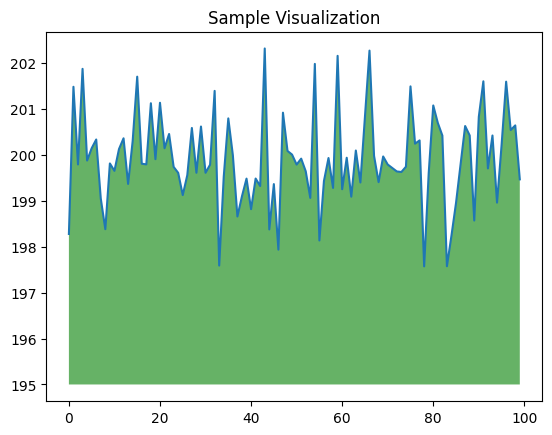

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()